In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import EarlyStopping

# Path to the training and testing directories
train_dir = r'D:\thesis\code\bangla_Handwritten_data\Train'
test_dir = r'D:\thesis\code\bangla_Handwritten_data\Test'

# Count the number of classes based on the number of subfolders in the training directory
num_classes = len(os.listdir(train_dir))

# Data Preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    # Other preprocessing techniques like rotation, zoom, etc. can be added here
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(50, 50),  # Resizing to 50x50 dimensions
    color_mode='grayscale',  # Convert images to grayscale
    batch_size=32,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(50, 50),  # Resizing to 50x50 dimensions
    color_mode='grayscale',  # Convert images to grayscale
    batch_size=32,
    class_mode='categorical')

# Model Architecture (ResNet-152V2)
inputs = layers.Input(shape=(50, 50, 1))
x = layers.Conv2D(64, 7, strides=2, padding='same')(inputs)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

# Residual Blocks
def residual_block_v2(x, filters, strides=1):
    shortcut = x
    if strides != 1 or x.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, 1, strides=strides, padding='same')(x)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Conv2D(filters, 3, strides=strides, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.add([shortcut, x])
    x = layers.Activation('relu')(x)
    return x

# Stack of residual blocks
x = residual_block_v2(x, filters=64, strides=1)
x = residual_block_v2(x, filters=64)
x = residual_block_v2(x, filters=64)

x = residual_block_v2(x, filters=128, strides=2)
x = residual_block_v2(x, filters=128)
x = residual_block_v2(x, filters=128)
x = residual_block_v2(x, filters=128)

x = residual_block_v2(x, filters=256, strides=2)
x = residual_block_v2(x, filters=256)
x = residual_block_v2(x, filters=256)
x = residual_block_v2(x, filters=256)
x = residual_block_v2(x, filters=256)
x = residual_block_v2(x, filters=256)

x = residual_block_v2(x, filters=512, strides=2)
x = residual_block_v2(x, filters=512)
x = residual_block_v2(x, filters=512)

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation='relu')(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

# Create Model
model = models.Model(inputs, outputs)

# Compile the Model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, mode='max', verbose=1)

# Training for potentially many epochs, but with early stopping
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples/train_generator.batch_size,
    epochs=20,  # Train potentially for many epochs
    validation_data=validation_generator,
    validation_steps=validation_generator.samples/validation_generator.batch_size,
    callbacks=[early_stopping]  # Pass the early stopping callback
)

# Evaluation
y_pred = model.predict(validation_generator)
y_true = validation_generator.classes

# Convert predictions to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Compute precision, recall, and F1-score
class_labels = list(validation_generator.class_indices.keys())
report = classification_report(y_true, y_pred_labels, target_names=class_labels)
print(report)

# Additional Evaluation (Accuracy)
test_loss, test_acc = model.evaluate(validation_generator)
print('Test accuracy:', test_acc)



Found 12000 images belonging to 50 classes.
Found 3000 images belonging to 50 classes.



Epoch 1/20


375/375 [==============================] - 796s 2s/step - loss: 2.0240 - accuracy: 0.4482 - val_loss: 4.7172 - val_accuracy: 0.0957
Epoch 2/20
375/375 [==============================] - 632s 2s/step - loss: 0.5473 - accuracy: 0.8257 - val_loss: 0.7034 - val_accuracy: 0.7710
Epoch 3/20
375/375 [==============================] - 665s 2s/step - loss: 0.3285 - accuracy: 0.8956 - val_loss: 0.4564 - val_accuracy: 0.8590
Epoch 4/20
375/375 [==============================] - 669s 2s/step - loss: 0.2137 - accuracy: 0.9316 - val_loss: 0.3499 - val_accuracy: 0.8967
Epoch 5/20
375/375 [==============================] - 569s 2s/step - loss: 0.1839 - accuracy: 0.9417 - val_loss: 0.4395 - val_accuracy: 0.8670
Epoch 6/20
375/375 [==============================] - 485s 1s/step - loss: 0.1390 - accuracy: 0.9558 - val_loss: 0.2477 - val_accuracy: 0.9237
Epoch 7/20
375/375 [=============================

Found 12000 images belonging to 50 classes.
Found 3000 images belonging to 50 classes.
Epoch 1/20
375/375 [==============================] - 188s 470ms/step - loss: 2.2675 - accuracy: 0.3798 - val_loss: 7.2073 - val_accuracy: 0.0530
Epoch 2/20
375/375 [==============================] - 172s 458ms/step - loss: 0.6147 - accuracy: 0.8048 - val_loss: 1.1902 - val_accuracy: 0.6793
Epoch 3/20
375/375 [==============================] - 169s 450ms/step - loss: 0.3440 - accuracy: 0.8930 - val_loss: 0.5524 - val_accuracy: 0.8427
Epoch 4/20
375/375 [==============================] - 169s 451ms/step - loss: 0.2475 - accuracy: 0.9228 - val_loss: 0.3286 - val_accuracy: 0.8967
Epoch 5/20
375/375 [==============================] - 171s 455ms/step - loss: 0.1785 - accuracy: 0.9437 - val_loss: 0.5501 - val_accuracy: 0.8547
Epoch 6/20
375/375 [==============================] - 171s 457ms/step - loss: 0.1549 - accuracy: 0.9498 - val_loss: 0.1824 - val_accuracy: 0.9420
Epoch 7/20
375/375 [=================

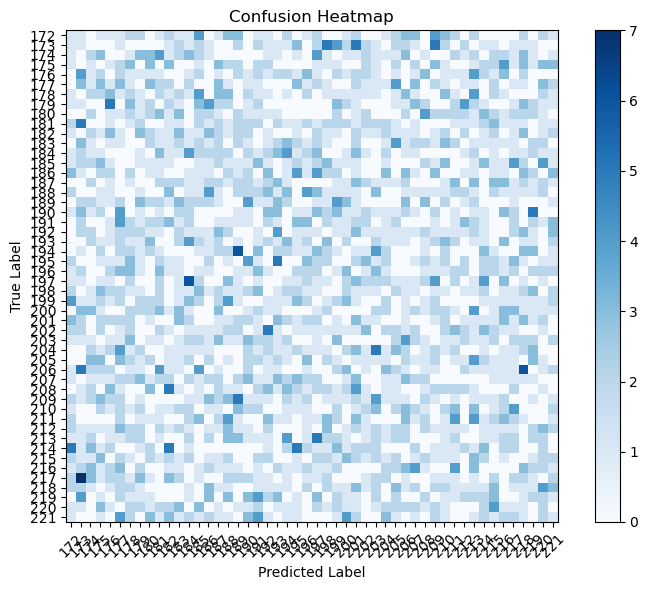

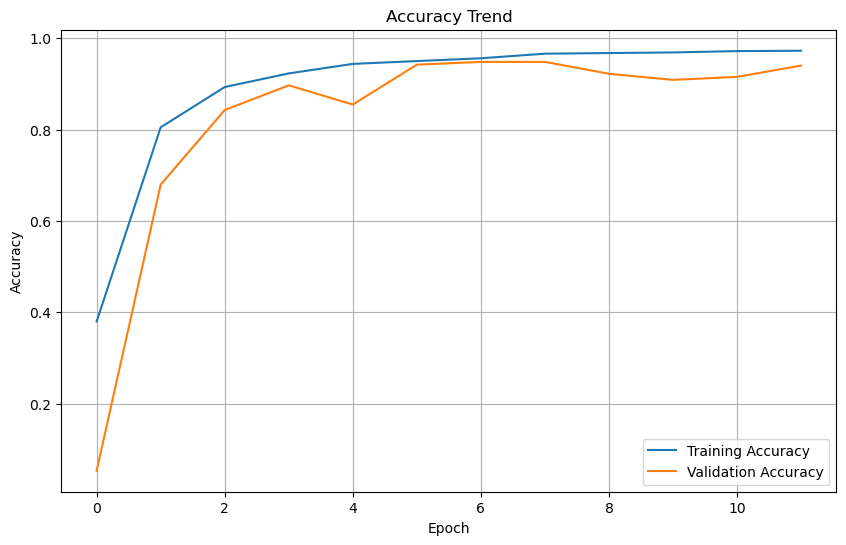

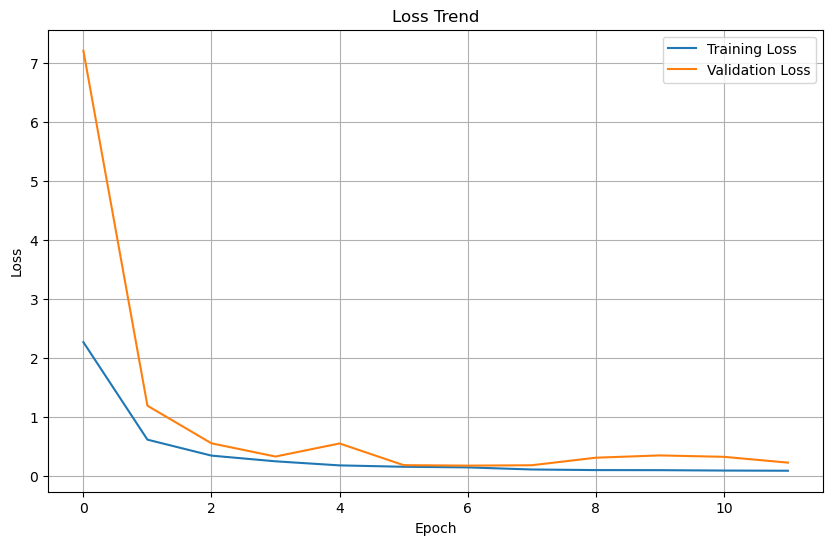

In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import EarlyStopping

# Path to the training and testing directories
train_dir = r'D:\thesis\code\bangla_Handwritten_data\Train'
test_dir = r'D:\thesis\code\bangla_Handwritten_data\Test'

# Count the number of classes based on the number of subfolders in the training directory
num_classes = len(os.listdir(train_dir))

# Data Preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    # Other preprocessing techniques like rotation, zoom, etc. can be added here
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(50, 50),  # Resizing to 50x50 dimensions
    color_mode='grayscale',  # Convert images to grayscale
    batch_size=32,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(50, 50),  # Resizing to 50x50 dimensions
    color_mode='grayscale',  # Convert images to grayscale
    batch_size=32,
    class_mode='categorical')

# Model Architecture (ResNet-152V2)
inputs = layers.Input(shape=(50, 50, 1))
x = layers.Conv2D(64, 7, strides=2, padding='same')(inputs)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

# Residual Blocks
def residual_block_v2(x, filters, strides=1):
    shortcut = x
    if strides != 1 or x.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, 1, strides=strides, padding='same')(x)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Conv2D(filters, 3, strides=strides, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.add([shortcut, x])
    x = layers.Activation('relu')(x)
    return x

# Stack of residual blocks
x = residual_block_v2(x, filters=64, strides=1)
x = residual_block_v2(x, filters=64)
x = residual_block_v2(x, filters=64)

x = residual_block_v2(x, filters=128, strides=2)
x = residual_block_v2(x, filters=128)
x = residual_block_v2(x, filters=128)
x = residual_block_v2(x, filters=128)

x = residual_block_v2(x, filters=256, strides=2)
x = residual_block_v2(x, filters=256)
x = residual_block_v2(x, filters=256)
x = residual_block_v2(x, filters=256)
x = residual_block_v2(x, filters=256)
x = residual_block_v2(x, filters=256)

x = residual_block_v2(x, filters=512, strides=2)
x = residual_block_v2(x, filters=512)
x = residual_block_v2(x, filters=512)

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation='relu')(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

# Create Model
model = models.Model(inputs, outputs)

# Compile the Model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, mode='max', verbose=1)

# Training for potentially many epochs, but with early stopping
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples/train_generator.batch_size,
    epochs=20,  # Train potentially for many epochs
    validation_data=validation_generator,
    validation_steps=validation_generator.samples/validation_generator.batch_size,
    callbacks=[early_stopping]  # Pass the early stopping callback
)

# Evaluation
y_pred = model.predict(validation_generator)
y_true = validation_generator.classes

# Convert predictions to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Compute precision, recall, and F1-score
class_labels = list(validation_generator.class_indices.keys())
report = classification_report(y_true, y_pred_labels, target_names=class_labels)
print(report)

# Additional Evaluation (Accuracy)
test_loss, test_acc = model.evaluate(validation_generator)
print('Test accuracy:', test_acc)


# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_labels)
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, cmap=plt.cm.Blues)
plt.title("Confusion Heatmap")
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# Accuracy Curve
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Trend')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss Curve
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Trend')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()



Found 12000 images belonging to 50 classes.
Found 3000 images belonging to 50 classes.



Epoch 1/35


375/375 [==============================] - 178s 443ms/step - loss: 2.6413 - accuracy: 0.2902 - val_loss: 5.3530 - val_accuracy: 0.1283
Epoch 2/35
375/375 [==============================] - 167s 444ms/step - loss: 0.7844 - accuracy: 0.7517 - val_loss: 0.5610 - val_accuracy: 0.8253
Epoch 3/35
375/375 [==============================] - 166s 442ms/step - loss: 0.3991 - accuracy: 0.8703 - val_loss: 0.5395 - val_accuracy: 0.8430
Epoch 4/35
375/375 [==============================] - 167s 445ms/step - loss: 0.2625 - accuracy: 0.9152 - val_loss: 0.4671 - val_accuracy: 0.8657
Epoch 5/35
375/375 [==============================] - 166s 442ms/step - loss: 0.1915 - accuracy: 0.9373 - val_loss: 0.3632 - val_accuracy: 0.8967
Epoch 6/35
375/375 [==============================] - 165s 441ms/step - loss: 0.1600 - accuracy: 0.9478 - val_loss: 0.4030 - val_accuracy: 0.8900
Epoch 7/35
375/375 [===========

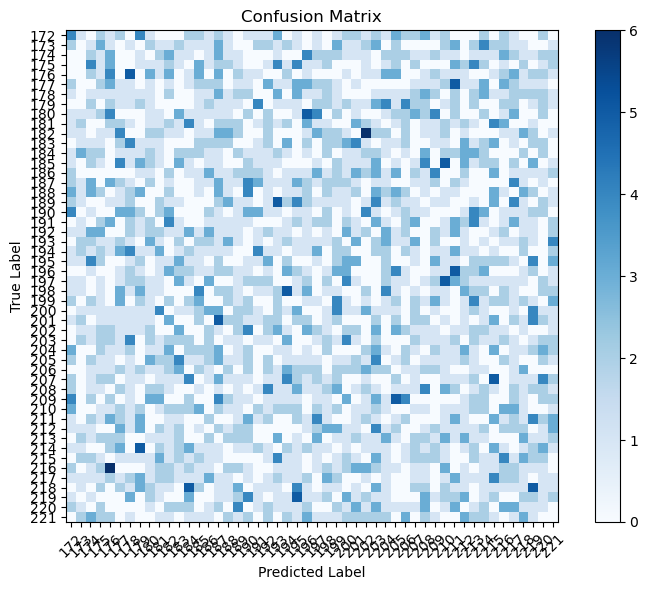

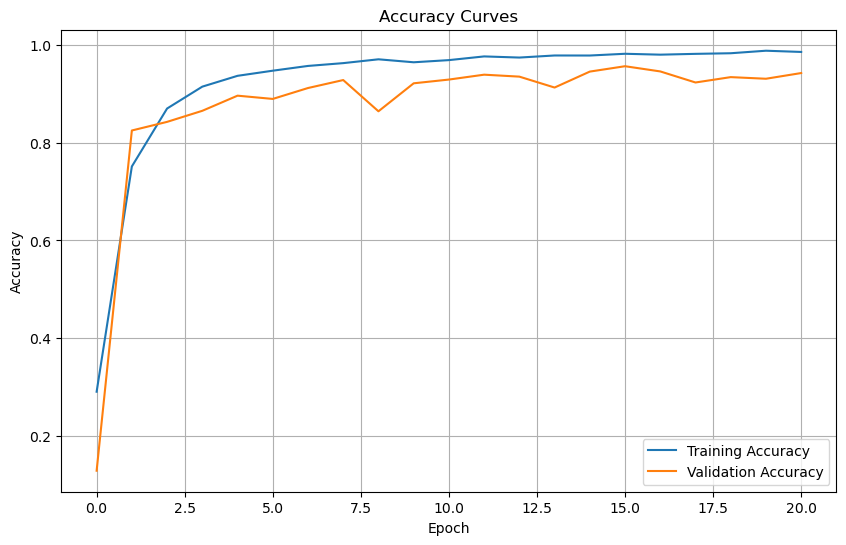

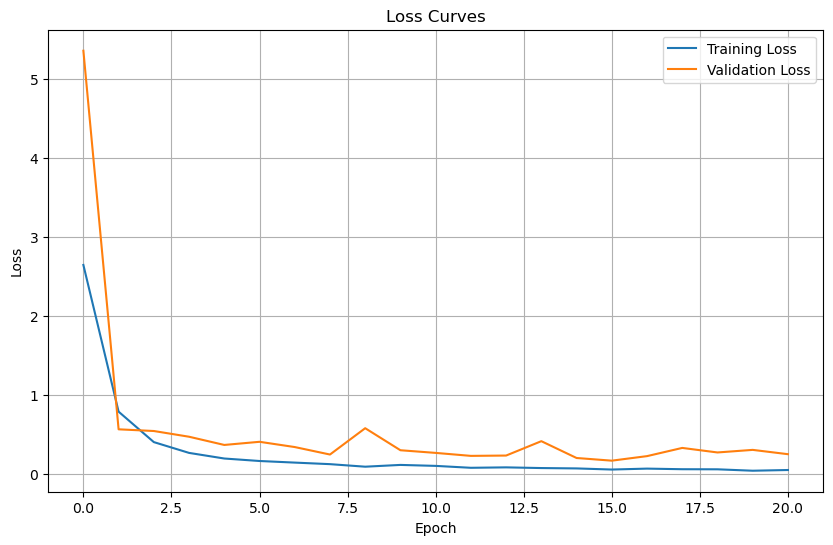

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Path to the training and testing directories
train_dir = r'D:\thesis\code\bangla_Handwritten_data\Train'
test_dir = r'D:\thesis\code\bangla_Handwritten_data\Test'

# Count the number of classes based on the number of subfolders in the training directory
num_classes = len(os.listdir(train_dir))

# Data Preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    # Other preprocessing techniques like rotation, zoom, etc. can be added here
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(50, 50),  # Resizing to 50x50 dimensions
    color_mode='grayscale',  # Convert images to grayscale
    batch_size=32,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(50, 50),  # Resizing to 50x50 dimensions
    color_mode='grayscale',  # Convert images to grayscale
    batch_size=32,
    class_mode='categorical')

# Model Architecture (ResNet-152V2)
inputs = layers.Input(shape=(50, 50, 1))
x = layers.Conv2D(64, 7, strides=2, padding='same')(inputs)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

# Residual Blocks
def residual_block_v2(x, filters, strides=1):
    shortcut = x
    if strides != 1 or x.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, 1, strides=strides, padding='same')(x)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Conv2D(filters, 3, strides=strides, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.add([shortcut, x])
    x = layers.Activation('relu')(x)
    return x

# Stack of residual blocks
x = residual_block_v2(x, filters=64, strides=1)
x = residual_block_v2(x, filters=64)
x = residual_block_v2(x, filters=64)

x = residual_block_v2(x, filters=128, strides=2)
x = residual_block_v2(x, filters=128)
x = residual_block_v2(x, filters=128)
x = residual_block_v2(x, filters=128)

x = residual_block_v2(x, filters=256, strides=2)
x = residual_block_v2(x, filters=256)
x = residual_block_v2(x, filters=256)
x = residual_block_v2(x, filters=256)
x = residual_block_v2(x, filters=256)
x = residual_block_v2(x, filters=256)

x = residual_block_v2(x, filters=512, strides=2)
x = residual_block_v2(x, filters=512)
x = residual_block_v2(x, filters=512)

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation='relu')(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

# Create Model
model = models.Model(inputs, outputs)

# Compile the Model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Define early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, mode='max', verbose=1)

# Training with early stopping
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples/train_generator.batch_size,
    epochs=35,  # Train potentially for many epochs
    validation_data=test_generator,
    validation_steps=test_generator.samples/test_generator.batch_size,
    callbacks=[early_stopping]  # Pass the early stopping callback
)

# Evaluation
y_pred = model.predict(test_generator)
y_true = test_generator.classes

# Convert predictions to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Compute precision, recall, and F1-score
class_labels = list(test_generator.class_indices.keys())
report = classification_report(y_true, y_pred_labels, target_names=class_labels)
print(report)

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_labels)
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# Accuracy Curves
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss Curves
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()



Found 12000 images belonging to 50 classes.
Found 3000 images belonging to 50 classes.



Epoch 1/34


375/375 [==============================] - 197s 495ms/step - loss: 1.9974 - accuracy: 0.4346 - val_loss: 6.3005 - val_accuracy: 0.0617
Epoch 2/34
375/375 [==============================] - 169s 450ms/step - loss: 0.5364 - accuracy: 0.8318 - val_loss: 0.8356 - val_accuracy: 0.7627
Epoch 3/34
375/375 [==============================] - 169s 449ms/step - loss: 0.3002 - accuracy: 0.9103 - val_loss: 0.3924 - val_accuracy: 0.8840
Epoch 4/34
375/375 [==============================] - 169s 451ms/step - loss: 0.2167 - accuracy: 0.9305 - val_loss: 0.5064 - val_accuracy: 0.8560
Epoch 5/34
375/375 [==============================] - 169s 450ms/step - loss: 0.1664 - accuracy: 0.9477 - val_loss: 0.2610 - val_accuracy: 0.9220
Epoch 6/34
375/375 [==============================] - 169s 450ms/step - loss: 0.1431 - accuracy: 0.9544 - val_loss: 0.4128 - val_accuracy: 0.8847
Epoch 7/34
375/375 [===========

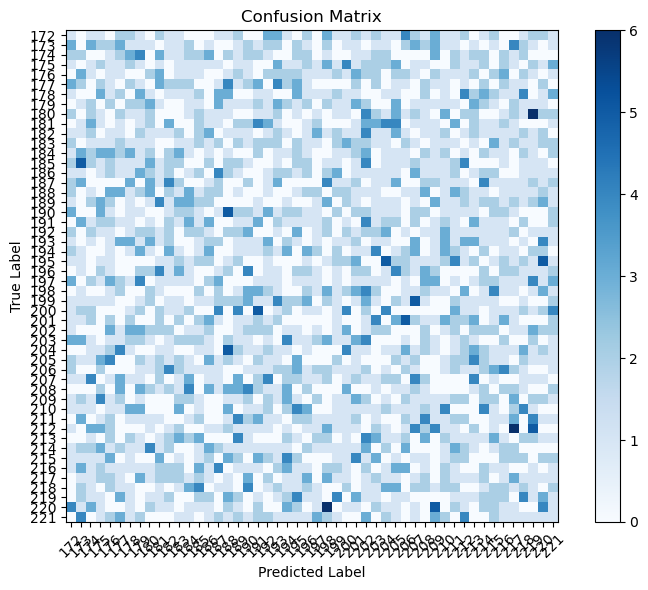

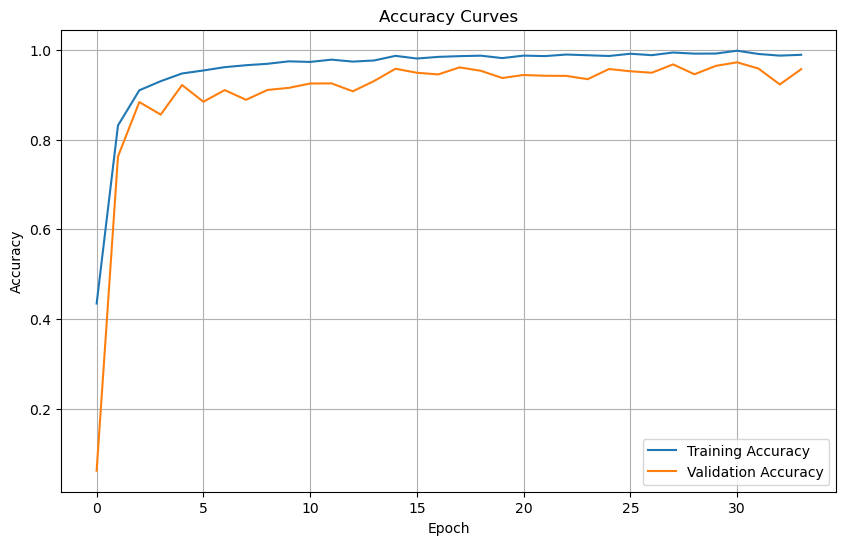

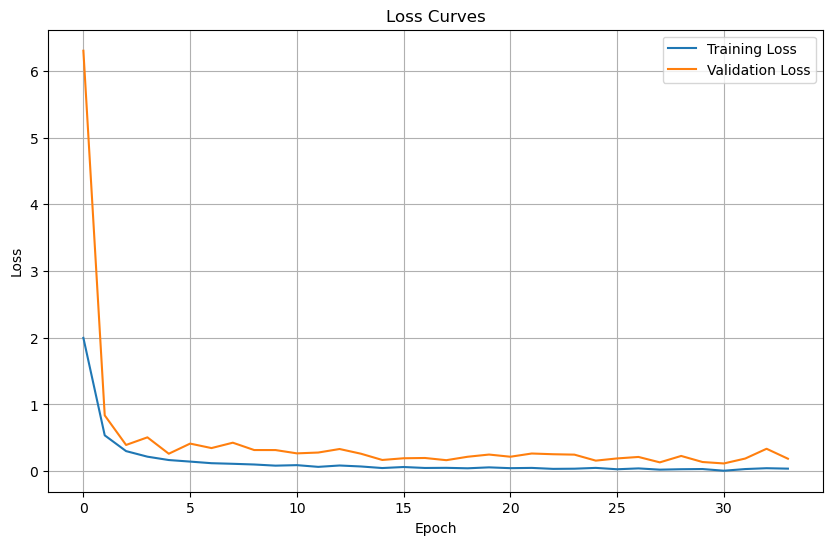

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Path to the training and testing directories
train_dir = r'D:\thesis\code\bangla_Handwritten_data\Train'
test_dir = r'D:\thesis\code\bangla_Handwritten_data\Test'

# Count the number of classes based on the number of subfolders in the training directory
num_classes = len(os.listdir(train_dir))

# Data Preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    # Other preprocessing techniques like rotation, zoom, etc. can be added here
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(50, 50),  # Resizing to 50x50 dimensions
    color_mode='grayscale',  # Convert images to grayscale
    batch_size=32,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(50, 50),  # Resizing to 50x50 dimensions
    color_mode='grayscale',  # Convert images to grayscale
    batch_size=32,
    class_mode='categorical')

# Model Architecture (ResNet-152V2)
inputs = layers.Input(shape=(50, 50, 1))
x = layers.Conv2D(64, 7, strides=2, padding='same')(inputs)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

# Residual Blocks
def residual_block_v2(x, filters, strides=1):
    shortcut = x
    if strides != 1 or x.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, 1, strides=strides, padding='same')(x)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Conv2D(filters, 3, strides=strides, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.add([shortcut, x])
    x = layers.Activation('relu')(x)
    return x

# Stack of residual blocks
x = residual_block_v2(x, filters=64, strides=1)
x = residual_block_v2(x, filters=64)
x = residual_block_v2(x, filters=64)

x = residual_block_v2(x, filters=128, strides=2)
x = residual_block_v2(x, filters=128)
x = residual_block_v2(x, filters=128)
x = residual_block_v2(x, filters=128)

x = residual_block_v2(x, filters=256, strides=2)
x = residual_block_v2(x, filters=256)
x = residual_block_v2(x, filters=256)
x = residual_block_v2(x, filters=256)
x = residual_block_v2(x, filters=256)
x = residual_block_v2(x, filters=256)

x = residual_block_v2(x, filters=512, strides=2)
x = residual_block_v2(x, filters=512)
x = residual_block_v2(x, filters=512)

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation='relu')(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

# Create Model
model = models.Model(inputs, outputs)

# Compile the Model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Training without early stopping for 34 epochs
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples/train_generator.batch_size,
    epochs=34,  # Train for 34 epochs
    validation_data=test_generator,
    validation_steps=test_generator.samples/test_generator.batch_size
)

# Evaluation
y_pred = model.predict(test_generator)
y_true = test_generator.classes

# Convert predictions to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Compute precision, recall, and F1-score
class_labels = list(test_generator.class_indices.keys())
report = classification_report(y_true, y_pred_labels, target_names=class_labels)
print(report)

# Calculate test accuracy
test_loss, test_acc = model.evaluate(test_generator)
print('Test accuracy:', test_acc)

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_labels)
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# Accuracy Curves
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss Curves
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


Found 12000 images belonging to 50 classes.
Found 3000 images belonging to 50 classes.
Epoch 1/34
375/375 [==============================] - 178s 443ms/step - loss: 2.0808 - accuracy: 0.4213 - val_loss: 5.7224 - val_accuracy: 0.1097
Epoch 2/34
375/375 [==============================] - 165s 441ms/step - loss: 0.5700 - accuracy: 0.8213 - val_loss: 0.4922 - val_accuracy: 0.8467
Epoch 3/34
375/375 [==============================] - 166s 442ms/step - loss: 0.3243 - accuracy: 0.8991 - val_loss: 1.1716 - val_accuracy: 0.7253
Epoch 4/34
375/375 [==============================] - 164s 436ms/step - loss: 0.2174 - accuracy: 0.9325 - val_loss: 0.3840 - val_accuracy: 0.8863
Epoch 5/34
375/375 [==============================] - 167s 445ms/step - loss: 0.1716 - accuracy: 0.9451 - val_loss: 0.4909 - val_accuracy: 0.8733
Epoch 6/34
375/375 [==============================] - 166s 444ms/step - loss: 0.1530 - accuracy: 0.9530 - val_loss: 0.3719 - val_accuracy: 0.8920
Epoch 7/34
375/375 [=================

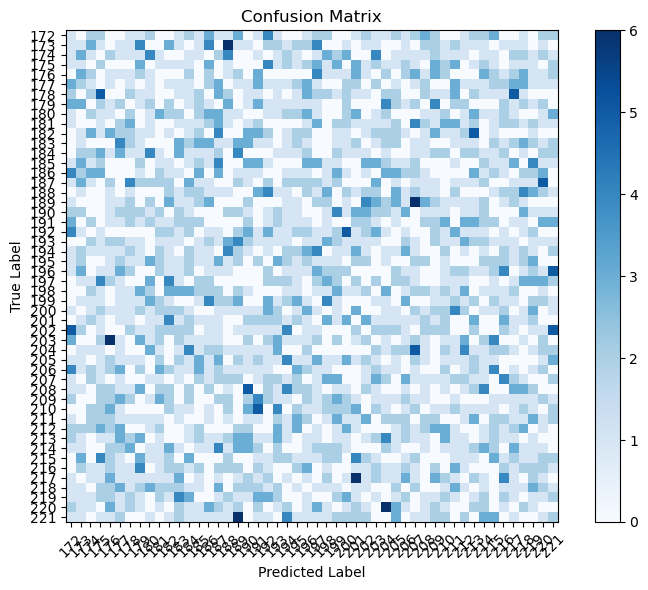

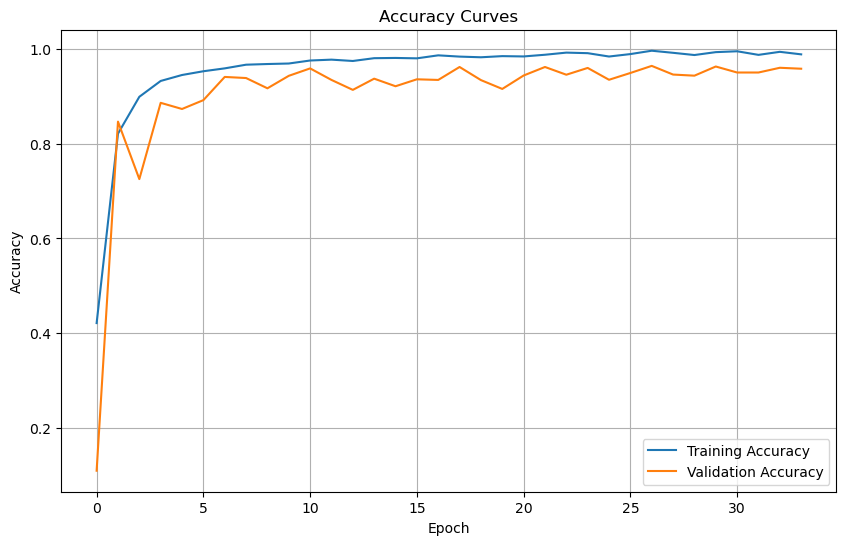

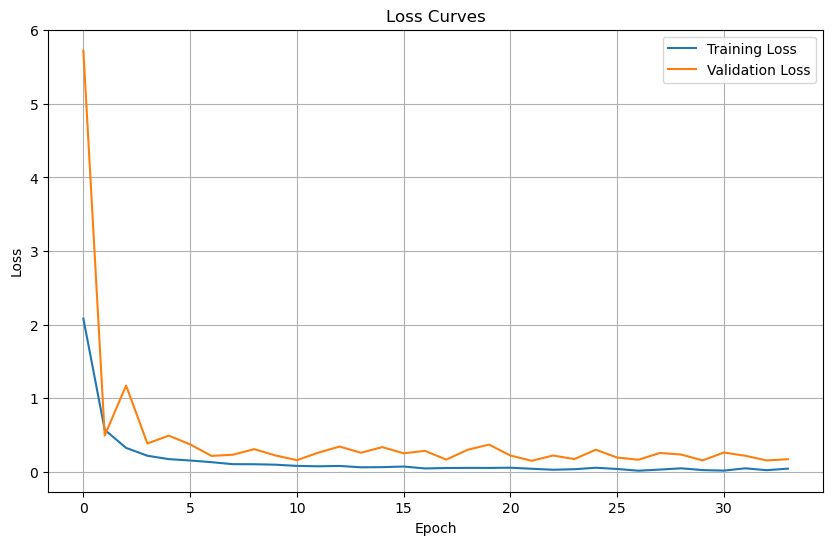

In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Path to the training and testing directories
train_dir = r'D:\thesis\code\bangla_Handwritten_data\Train'
test_dir = r'D:\thesis\code\bangla_Handwritten_data\Test'

# Count the number of classes based on the number of subfolders in the training directory
num_classes = len(os.listdir(train_dir))

# Data Preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    # Other preprocessing techniques like rotation, zoom, etc. can be added here
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(50, 50),  # Resizing to 50x50 dimensions
    color_mode='grayscale',  # Convert images to grayscale
    batch_size=32,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(50, 50),  # Resizing to 50x50 dimensions
    color_mode='grayscale',  # Convert images to grayscale
    batch_size=32,
    class_mode='categorical')

# Model Architecture (ResNet-152V2)
inputs = layers.Input(shape=(50, 50, 1))
x = layers.Conv2D(64, 7, strides=2, padding='same')(inputs)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

# Residual Blocks
def residual_block_v2(x, filters, strides=1):
    shortcut = x
    if strides != 1 or x.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, 1, strides=strides, padding='same')(x)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Conv2D(filters, 3, strides=strides, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.add([shortcut, x])
    x = layers.Activation('relu')(x)
    return x

# Stack of residual blocks
x = residual_block_v2(x, filters=64, strides=1)
x = residual_block_v2(x, filters=64)
x = residual_block_v2(x, filters=64)

x = residual_block_v2(x, filters=128, strides=2)
x = residual_block_v2(x, filters=128)
x = residual_block_v2(x, filters=128)
x = residual_block_v2(x, filters=128)

x = residual_block_v2(x, filters=256, strides=2)
x = residual_block_v2(x, filters=256)
x = residual_block_v2(x, filters=256)
x = residual_block_v2(x, filters=256)
x = residual_block_v2(x, filters=256)
x = residual_block_v2(x, filters=256)

x = residual_block_v2(x, filters=512, strides=2)
x = residual_block_v2(x, filters=512)
x = residual_block_v2(x, filters=512)

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation='relu')(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

# Create Model
model = models.Model(inputs, outputs)

# Compile the Model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Training without early stopping for 34 epochs
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples/train_generator.batch_size,
    epochs=34,  # Train for 34 epochs
    validation_data=test_generator,
    validation_steps=test_generator.samples/test_generator.batch_size
)

# Evaluation
y_pred = model.predict(test_generator)
y_true = test_generator.classes

# Convert predictions to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Compute precision, recall, and F1-score
class_labels = list(test_generator.class_indices.keys())
report = classification_report(y_true, y_pred_labels, target_names=class_labels)
print(report)

# Calculate test accuracy
test_loss, test_acc = model.evaluate(test_generator)
print('Test accuracy:', test_acc)

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_labels)
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# Accuracy Curves
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss Curves
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()